# Classification

Explore classification systems.

# MNIST

MNIST is a dataset of 70,000 small handwritten digits.

### OpenML

According to the official [OpenML](https://www.openml.org/) site description: *"OpenML is an open platform for sharing datasets, algorithms, and experiments - to learn how to learn better, together."*

`scikit-learn` provides [fetch_openml](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html) API to download datasets from the OpenML [datasets collection](https://www.openml.org/search?type=data&sort=runs&status=active) (which also includes `Fashion-MNIST`).

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, data_home="./datasets")
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
import numpy as np

X = mnist["data"].to_numpy()
y = mnist["target"].to_numpy().astype(np.uint8)

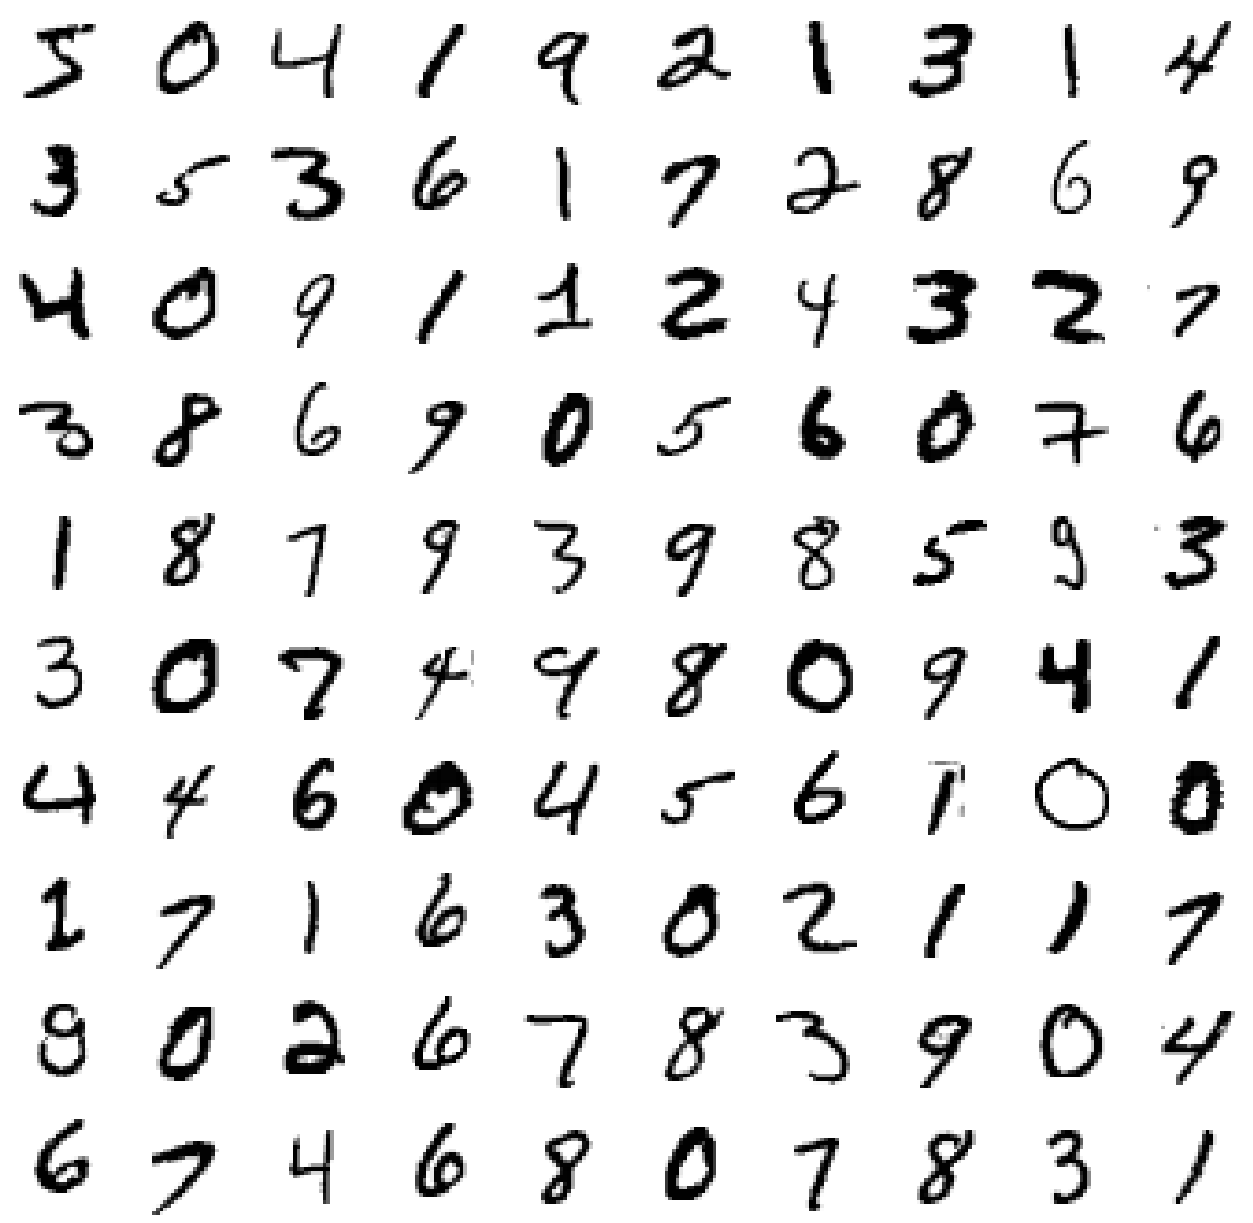

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20), dpi=80)
w, h = 10, 10
for i in range(w * h):
    axes = fig.add_subplot(w, h, i+1)
    digit = X[i].reshape(28, 28)
    axes.imshow(digit, cmap=mpl.cm.binary, interpolation="nearest")
    axes.axis("off")

In [4]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

### Create Test Set

MNIST is already split into a training set (the firt 60k) and test set (the last 10k)

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

Let's create labels for binary classifier. 

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_train_5

array([ True, False, False, ...,  True, False, False])

Let's start with Stochastic Gradient Descent (SGD) classifier, which is capable of handling very large datasets efficiently. This is due to the fact that SGD deals with training instances independently (which makes it suitable for *online learning*). 

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict(X[:20])

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False])

In [9]:
y_train_5[:20]

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False])

# Performance Measures

Evaluating classifier is often significant trikier (*but why?*). There are many performance measures. 

In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    sgd_clf, 
    X_train, 
    y_train_5, 
    scoring="accuracy", 
    cv=3,
)

scores

array([0.95035, 0.96035, 0.9604 ])

The accuracy is pretty high! 

**BUT WAIT!**

What is the proportion of the 5s in the original dataset?

In [11]:
ratio = float(sum(y_train_5))/len(y_train)
print("Portion:", ratio)
print("All negative accuracy:", 1 - ratio)

Portion: 0.09035
All negative accuracy: 0.90965


Let's create a dummy all-negative binary classifier. 

In [12]:
from sklearn.base import BaseEstimator

class NeverClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = NeverClassifier()
cross_val_score(
    never_5_clf,
    X_train,
    y_train_5,
    scoring="accuracy",
    cv=3
)

array([0.91125, 0.90855, 0.90915])

**NOTE**: Almost the save accuracy as for `SGDClassifier`! This is simply because only ~10% of the images are 5s.

**This demonstrates why accuracy is generally not the preferred performance measure for classifiers**, especially with *skewed datasets* (i.e. when some classes are much more frequent than others).

# Confusion Matrix

Each row in a confusion matrix represents an actual class, while each column represents a predicted class

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Get cross-validation predictions:
y_train_5_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
conf_matrix = confusion_matrix(y_train_5, y_train_5_pred)
conf_matrix

array([[53892,   687],
       [ 1891,  3530]])

# Precision and Recall

Let's try to calculate $precision = \frac{TP}{TP+FP}$

In [14]:
float(conf_matrix[1,1])/sum(conf_matrix[:, 1])

0.8370879772350012

Let's calculate $recall = \frac{TP}{TP + FN}$

In [15]:
float(conf_matrix[1,1])/sum(conf_matrix[1])

0.6511713705958311

Scikit-Learn provides API to calculate classifier metrics:

In [16]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_5_pred)

0.8370879772350012

In [17]:
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_5_pred)

0.6511713705958311

A convenient way to combine *precission* and *recall* is to use the $F_1$ metric. This is a handy tool to compare two classifiers. The $F_1$ metric is a *harmonic mean* of precision and recall. 

**NOTE**: the harmonic mean gives much more weight to low values, i.e. the classifier will only get a high $F_1$ score if both recall and precision are high:

$$
F_1 = 2 \times \frac{precision \times recall}{precision+recall}
$$

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_5_pred)

0.7325171197343846

# Precision/Recall Tradeoff

The binary `SGDClassifier` computes scores for each instance and then decides that this is a `True`-class if `score > threshold`

Let's compute scores for each instance from the training set.

In [19]:
y_scores = cross_val_predict(
    sgd_clf, 
    X_train, 
    y_train_5, 
    cv=5,
    method="decision_function"
)

In [20]:
y_scores

array([  4411.53413566, -14087.12193543, -21565.51993633, ...,
         9394.4695853 ,  -2918.25117218,  -9160.6081938 ])

Now that we have scores for each instance we can compute a precision and recall for different `threshold` values and plot the corresponding graphs. The Scikit-Learn's [precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) function does exactly that. 

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(
    y_train_5,
    y_scores
)

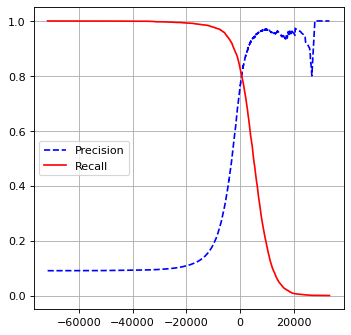

In [22]:
def plot_precision_recall(precisions, recalls, thresholds):
    fig = plt.figure(figsize=(5, 5), dpi=80)
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(thresholds, precisions[:-1], "b--", label="Precision")
    axes.plot(thresholds, recalls[:-1], "r", label="Recall")
    axes.grid(visible=True)
    axes.legend()
    
plot_precision_recall(precisions, recalls, thresholds)

**NOTE** that there is a trade-off between precision and recall. The highest values of the precision presumes the lowest recall and vice-versa. 

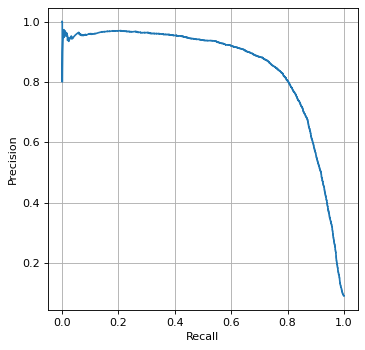

In [23]:
fig = plt.figure(figsize=(5,5), dpi=80)
axes = fig.add_subplot(1, 1, 1)
axes.plot(recalls, precisions)
axes.set_xlabel("Recall")
axes.set_ylabel("Precision")
axes.grid(visible=True)

**NOTE** that precision starts to fall sharply around 80% recall. The choice of precision/recall depends on the project.

# The ROC Curve

The *receiver operating characteristic* (ROC) curve is recall (also a *true positive rate*, TPR) vs *false positive rate* (FPR). The FPR is portion of negative instances that were incorrectly classified as positive.

$$
FPR = \frac{FP}{FP + TN}
$$

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Text(0, 0.5, 'Recall (True Positive Rate)')

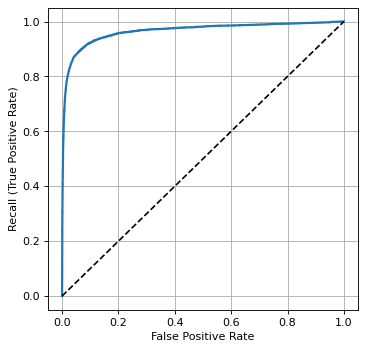

In [25]:
fig = plt.figure(figsize=(5, 5), dpi=80)
axes = fig.add_subplot(1, 1, 1)
axes.plot(fpr, tpr, linewidth=2, label="Recall vs False Positive")
axes.plot([0, 1], [0, 1], "k--")
axes.grid(visible=True)
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("Recall (True Positive Rate)")

Let's compare with purely random classifier, just for fun! =))

In [26]:
import numpy.random


class RandomClassifier(BaseEstimator):
    def fit(self, X, y=None):
        self.threshold = 1000 * sum(y) / len(X)
        self.classes_ = [False, True]
    def predict(self, X):
        return self.decision_function(X) > 900
    def decision_function(self, X):
        return np.random.randint(0, 1000, size=len(X))

    
random_clf = RandomClassifier()
cross_val_score(random_clf, X_train, y_train_5, scoring="accuracy", cv=3)

array([0.83205, 0.8274 , 0.8286 ])

In [27]:
y_scores_random = cross_val_predict(random_clf, X_train, y_train_5, cv=5, method="decision_function")
fpr_random, tpr_random, thresholds_random = roc_curve(y_train_5, y_scores_random)

Text(0, 0.5, 'Recall (True Positive Rate)')

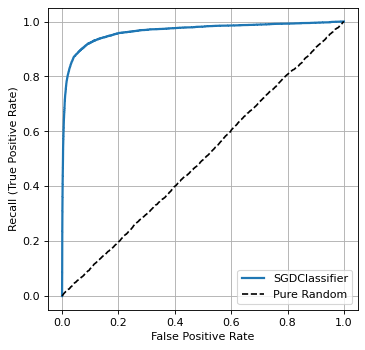

In [28]:
fig = plt.figure(figsize=(5, 5), dpi=80)
axes = fig.add_subplot(1, 1, 1)
axes.plot(fpr, tpr, linewidth=2, label="SGDClassifier")
axes.plot(fpr_random, tpr_random, "k--", label="Pure Random")
axes.grid(visible=True)
axes.legend()
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("Recall (True Positive Rate)")

**NOTE** The higher the True Positive Rate level could be achieved without significantly increasing FPR, the better the classifier. So we want classifiers with steeper ROC Curve at the begining. 

Let's calculate ROC *area under the curve* (AUC) which is another performance measure 

In [29]:
from sklearn.metrics import roc_auc_score

print("SGDClassifier AUC:", roc_auc_score(y_train_5, y_scores))
print("Pure Random AUC:", roc_auc_score(y_train_5, y_scores_random))

SGDClassifier AUC: 0.9648211175804801
Pure Random AUC: 0.5010797834213592


# Compare with Random Forest

Let's get the same measures for RandomForestClassifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()

cross_val_score(
    forest_clf, 
    X_train, 
    y_train_5, 
    cv=3, 
    scoring="accuracy"
)

array([0.9894, 0.986 , 0.987 ])

In [31]:
y_train_5_pred_forest = cross_val_predict(
    forest_clf,
    X_train,
    y_train_5,
    cv=5
)

In [32]:
precision_score(y_train_5, y_train_5_pred_forest)

0.9897874114214256

In [33]:
recall_score(y_train_5, y_train_5_pred_forest)

0.8760376314333149

In [34]:
f1_score(y_train_5, y_train_5_pred_forest)

0.9294451511889618

**NOTE**: much better than 0.73 for SGDClassifier!

In [35]:
y_score_forest = cross_val_predict(
    forest_clf,
    X_train,
    y_train_5,
    cv=5,
    method="predict_proba"
)[:, 1]

In [36]:
y_score_forest

array([0.87, 0.02, 0.04, ..., 0.96, 0.08, 0.09])

In [37]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5,
    y_score_forest,
)

overlap_forest = np.minimum(precisions_forest, recalls_forest)

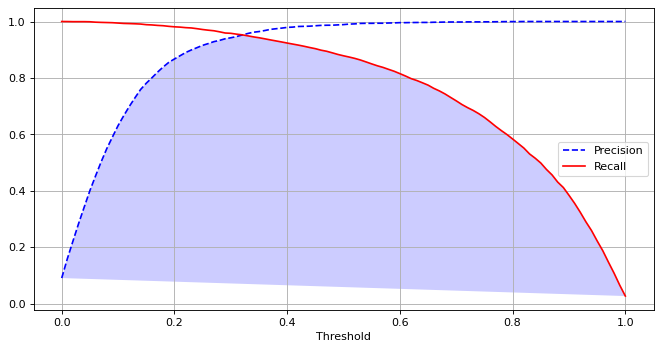

In [38]:
fig = plt.figure(figsize=(10, 5), dpi=80)
axes = fig.add_subplot(1, 1, 1)
axes.plot(thresholds_forest, precisions_forest[:-1], "b--", label="Precision")
axes.plot(thresholds_forest, recalls_forest[:-1], "r", label="Recall")
axes.fill(thresholds_forest, overlap_forest[:-1], facecolor="blue", alpha=0.2)
axes.grid(visible=True)
axes.set_xlabel("Threshold")
axes.legend()

**NOTE**: The precision and recall has much greater overlapping area than for `SGDClassifier`

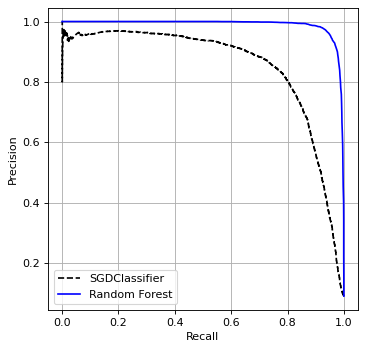

In [39]:
fig = plt.figure(figsize=(5,5), dpi=80)
axes = fig.add_subplot(1, 1, 1)
axes.plot(recalls, precisions, "k--", label="SGDClassifier")
axes.plot(recalls_forest, precisions_forest, "b", label="Random Forest")
axes.set_xlabel("Recall")
axes.set_ylabel("Precision")
axes.legend()
axes.grid(visible=True)

In [40]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(
    y_train_5, 
    y_score_forest
)

Text(0, 0.5, 'Recall (True Positive Rate)')

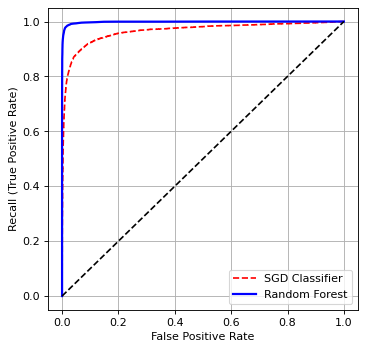

In [41]:
fig = plt.figure(figsize=(5, 5), dpi=80)
axes = fig.add_subplot(1, 1, 1)
axes.plot(fpr, tpr, "r--", label="SGD Classifier")
axes.plot(fpr_forest, tpr_forest, "b", linewidth=2, label="Random Forest")
axes.plot([0, 1], [0, 1], "k--")
axes.grid(visible=True)
axes.legend()
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("Recall (True Positive Rate)")

In [42]:
print("SGDClassifier AUC:", roc_auc_score(y_train_5, y_scores))
print("Random Forest AUC:", roc_auc_score(y_train_5, y_score_forest))

SGDClassifier AUC: 0.9648211175804801
Random Forest AUC: 0.9983633758591477


# Multiclass Classification

Some classifiers are inherently binary. Multiple binary classifiers could be combined into a single multiclass one. Wide-spread strategies to do that:
* **OvA** (one vs. all) - when for $N$ classes you train $N$ binary single-class detectors and then select a class with the highest confidence 
* **OvO** (one vs. one) - when $N \times (N - 1)$ classifiers are trained (for each class pair). The result is the class that wins most duels. 

SGDClassifier is based on SVM model which is inherently binary. Scikit-Learn detects when binary model is used for multiclass classification and automatically uses OvA strategy (except for SVM for which it uses OvO due to its poor time-performance on large datasets).

### SGD MultiClass Classifier

Now let's use `SGDClassifier` for all 10 digit classes.

In [43]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

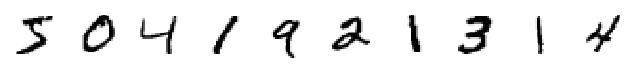

In [44]:
examples = 10
fig = plt.figure(figsize=(10, 1), dpi=80)
for i in range(examples):
    axes = fig.add_subplot(1, examples, i+1)
    digit = X_train[i].reshape(28, 28)
    axes.imshow(digit, cmap=mpl.cm.binary, interpolation="nearest")
    axes.axis("off")

In [45]:
sgd_clf.predict(X_train[:examples])

array([3, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [46]:
sgd_clf.decision_function(X_train[:1])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [47]:
best_cls_index = np.argmax(sgd_clf.decision_function(X_train[:1]))
sgd_clf.classes_[best_cls_index]

3

### Random Forest

In [48]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)

RandomForestClassifier()

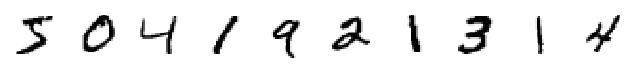

In [49]:
examples = 10
fig = plt.figure(figsize=(10, 1), dpi=80)
for i in range(examples):
    axes = fig.add_subplot(1, examples, i+1)
    digit = X_train[i].reshape(28, 28)
    axes.imshow(digit, cmap=mpl.cm.binary, interpolation="nearest")
    axes.axis("off")

In [50]:
forest_clf.predict(X_train[:examples])

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

### Evaluation

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [52]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9659 , 0.96195, 0.96505])

**NOTE**: Results are not bad! For 10 classes the accuracy of purely random classifier would be ~10%. Even for SGD classifier it is 85%.

**COMMENT**: simple scaling of the inputs (recall `MinMaxScaler` and `StandardScaler` from `sklearn.preprocessing`) would increase `SGDClassifier` performance up to ~90%

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [54]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Let's draw the confusion matrix.

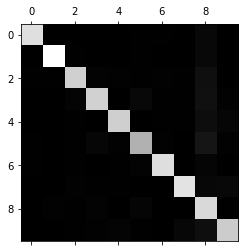

In [55]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.matshow(conf_mx, cmap=plt.cm.gray)

**NOTE**: this confusion matrix looks quite good, since most results are on the main diagonal (i.e. they were classified correctly). The 5s looks slightly darker, which could mean that there are fewer images of 5s in the dataset or that the classifier performs better on other classes. 

Now let's focus on the error rates of the confusion matrix.

We will need to normalize each raw, otherwise more abundant classes will look unfairly bad.

In [56]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

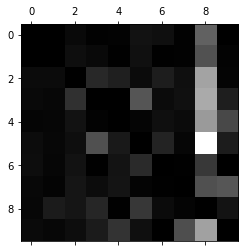

In [57]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.matshow(norm_conf_mx, cmap=plt.cm.gray)

**NOTE**: most of the digits are confused with 8, haha! (Rows represent actual classes, while columns represent predicted classes)

**NOTE**: symmetrical bright squares for 3 and 5 indicate that these digits often get confused (in both directions).

Now let's take a look how confused 3s and 5s look like.

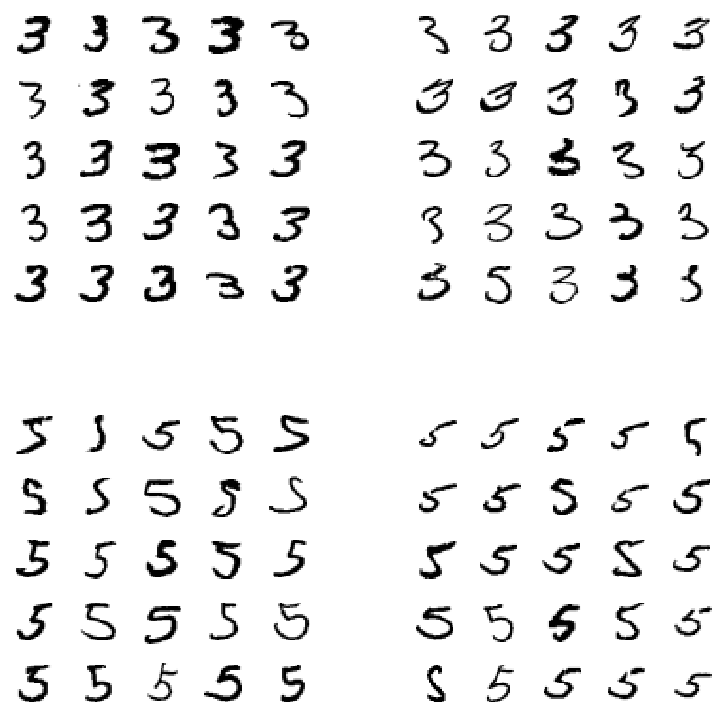

In [62]:
def plot_digits(X, rows, fig):
    for i in range(rows**2):
        axes = fig.add_subplot(rows, rows, i+1)
        digit = X[i].reshape(28, 28)
        axes.imshow(
            digit, cmap=mpl.cm.binary, interpolation="nearest"
        )
        axes.axis("off")
        
def subfig(fig, h, w, i):
    axes = fig.add_subplot(h, w, i)
    axes.axis("off")
    return fig.add_subfigure(axes.get_subplotspec())

def show_confusion(
    rows, X, y, y_pred, cl_a, cl_b, figsize=(10,10), dpi=80
):
    X_aa = X[(y == cl_a) & (y_pred == cl_a)]
    X_ab = X[(y == cl_a) & (y_pred == cl_b)]
    X_ba = X[(y == cl_b) & (y_pred == cl_a)]
    X_bb = X[(y == cl_b) & (y_pred == cl_b)]
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plot_digits(X_aa, rows=5, fig=subfig(fig, 2, 2, 1))
    plot_digits(X_ab, rows=5, fig=subfig(fig, 2, 2, 2))
    plot_digits(X_ba, rows=5, fig=subfig(fig, 2, 2, 3))
    plot_digits(X_bb, rows=5, fig=subfig(fig, 2, 2, 4))
    
show_confusion(5, X_train, y_train, y_train_pred, 3, 5)

**COMMENT**: Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them (e.g., the 5 on the 1 st row and 2 nd column truly looks like a badly written 3). However, most misclassified images seem like obvious errors to us.

### Random Forest Error Analysis

Let's do the same for the Random Forest Classifier

In [63]:
fores_clf = RandomForestClassifier()

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3)
conf_mx_forest = confusion_matrix(y_train, y_train_pred_forest)

In [64]:
conf_mx_forest

array([[5846,    1,   12,    2,    5,    7,   20,    1,   26,    3],
       [   0, 6646,   32,   14,   10,    3,    6,   12,   13,    6],
       [  28,   13, 5753,   26,   33,    4,   17,   37,   37,   10],
       [   9,    8,   94, 5811,    3,   65,    8,   48,   55,   30],
       [  10,   10,   12,    2, 5648,    2,   30,   14,   18,   96],
       [  26,    8,   10,   68,    8, 5181,   51,    6,   36,   27],
       [  28,   10,    4,    0,   11,   37, 5812,    0,   16,    0],
       [   5,   23,   61,    6,   38,    1,    1, 6038,   14,   78],
       [  12,   33,   38,   48,   26,   49,   25,    6, 5544,   70],
       [  23,   12,   18,   75,   78,   21,    3,   52,   35, 5632]])

In [65]:
norm_conf_mx_forest = conf_mx / conf_mx.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mx_forest, 0)

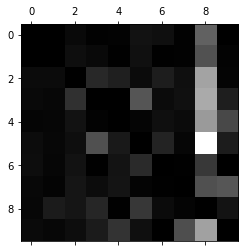

In [66]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.matshow(norm_conf_mx_forest, cmap=plt.cm.gray)

**NOTE** Very similar kinds of errors to SVM model. It should be the feature of the data itself!

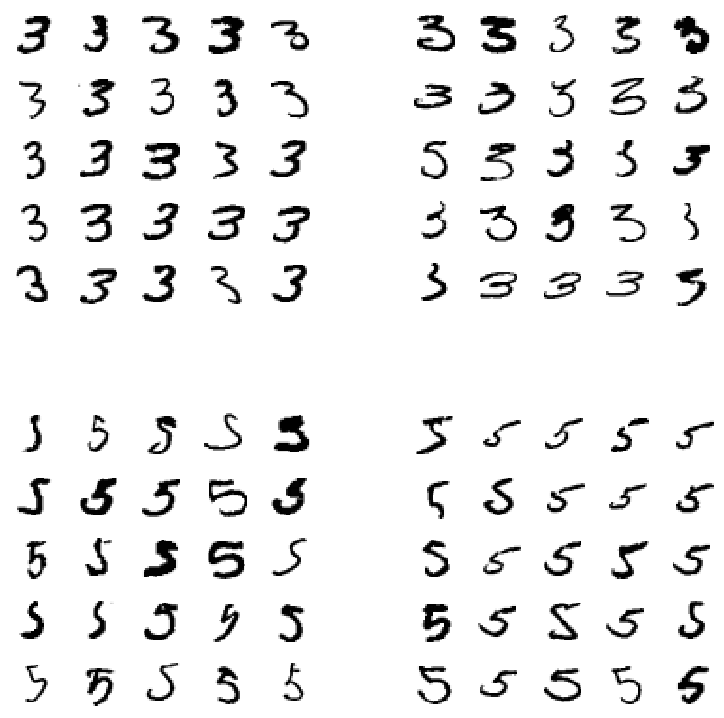

In [67]:
show_confusion(5, X_train, y_train, y_train_pred_forest, 3, 5)

**NOTE** that for `RandomForestClassifier` the confused instances are much more similar than it was for SVM model. 

# Multilabel Classification

`KNeighborsClassifier` supports multilabel classification, but not all classifiers do.

In [68]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [69]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

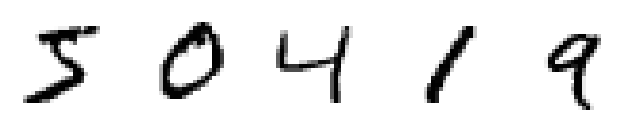

In [70]:
examples = 5
fig = plt.figure(figsize=(10, 2), dpi=80)
for i in range(examples):
    axes = fig.add_subplot(1, examples, i+1)
    digit = X_train[i].reshape(28, 28)
    axes.imshow(digit, cmap=mpl.cm.binary, interpolation="nearest")
    axes.axis("off")

In [71]:
knn_clf.predict(X_train[:examples])

array([[False,  True],
       [False, False],
       [False, False],
       [False,  True],
       [ True,  True]])

Whoa! All correct!

In [72]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

Actually $F_1$ = 0.976 is not bad at all!

# Multioutput Classification

It is simply a generalization of multilabel classification where each label can be multiclass.

Let's create a KNN classifier which will clear MNIST images from noise.

In [73]:
from sklearn.neighbors import KNeighborsClassifier

noise = np.random.randint(0, 100, X_train.shape)
X_train_noisy = X_train + noise

noise = np.random.randint(0, 100, X_test.shape)
X_test_noisy = X_test + noise

knn_clf = KNeighborsClassifier()
clear_digits = cross_val_predict(knn_clf, X_train_noisy, X_train, cv=3)

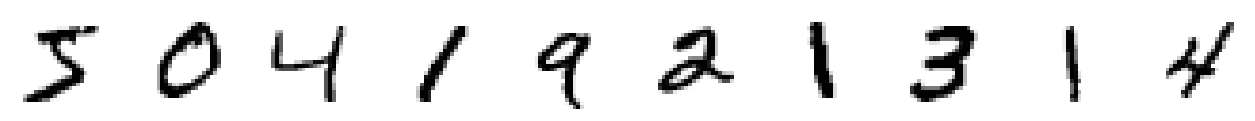

In [77]:
def show_digits(X, rows=1, columns=10):
    fig = plt.figure(figsize=(2*columns, 2*rows), dpi=80)
    for i in range(rows*columns):
        axes = fig.add_subplot(rows, columns, i+1)
        digit = X[i].reshape(28, 28)
        axes.imshow(digit, cmap=mpl.cm.binary, interpolation="nearest")
        axes.axis("off")
        
show_digits(X_train)

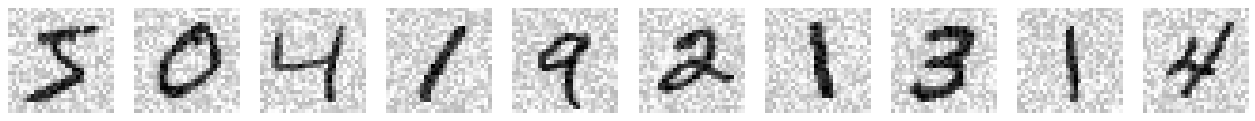

In [78]:
show_digits(X_train_noisy)

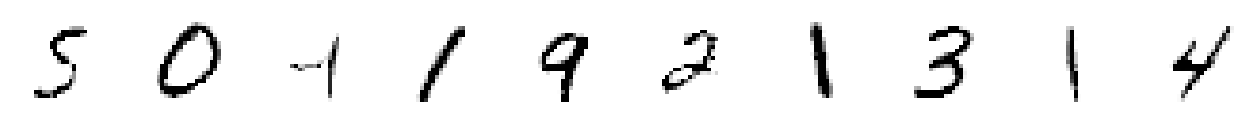

In [79]:
show_digits(clear_digits)